In [1]:
# Import necessary libraries for data manipulation, plotting, and machine learning
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [2]:
# Load the datasets from CSV files into pandas DataFrames
books = pd.read_csv('Dataset/Books.csv')
ratings = pd.read_csv('Dataset/Ratings.csv')

# Print the shapes of the DataFrames to see the number of rows and columns
print("Books shape:", books.shape)
print("Ratings shape:", ratings.shape)

Books shape: (200, 4)
Ratings shape: (1000, 3)


C:\Users\Shivam Vishwakarma\AppData\Local\Temp\ipykernel_13932\3582131939.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Book-Rating', data=ratings, palette='viridis')


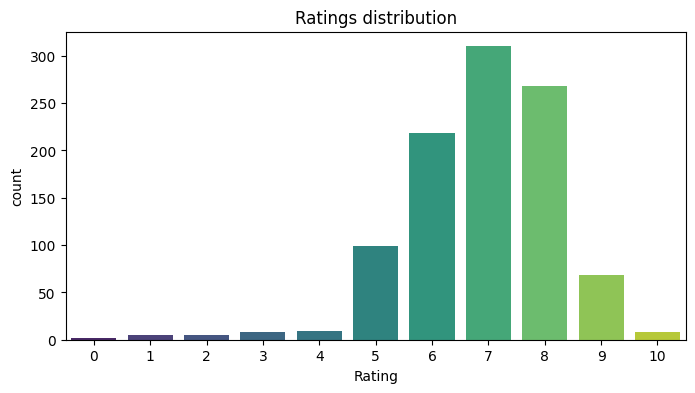

In [3]:
# Create a countplot to visualize the distribution of book ratings
plt.figure(figsize=(8,4))
sns.countplot(x='Book-Rating', data=ratings, palette='viridis')
plt.title("Ratings distribution") # Set the title of the plot
plt.xlabel("Rating") # Set the label for the x-axis
plt.show() # Display the plot

In [4]:
# Find the top 10 most rated books
top_isbns = ratings['ISBN'].value_counts().head(10).index

# Get the information for the top 10 books
top_books_info = books[books['ISBN'].isin(top_isbns)][['ISBN','Book-Title','Book-Author']].drop_duplicates()
print("Top 10 most-rated books (ISBN -> title):")
display(top_books_info)

Top 10 most-rated books (ISBN -> title):


,ISBN,Book-Title,Book-Author
76,77,The Brothers Karamazov,Fyodor Dostoevsky
80,81,The Old Man and the Sea,Ernest Hemingway
115,116,Divergent,Veronica Roth
129,130,Cosmos,Carl Sagan
133,134,The 7 Habits of Highly Effective People,Stephen Covey
134,135,Harry Potter and the Order of the Phoenix,J.K. Rowling
142,143,Fahrenheit 451,Ray Bradbury
153,154,The Grapes of Wrath,John Steinbeck
158,159,A Farewell to Arms,Ernest Hemingway
183,184,The Count of Monte Cristo,Alexandre Dumas


C:\Users\Shivam Vishwakarma\AppData\Local\Temp\ipykernel_13932\3939299168.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette="magma")


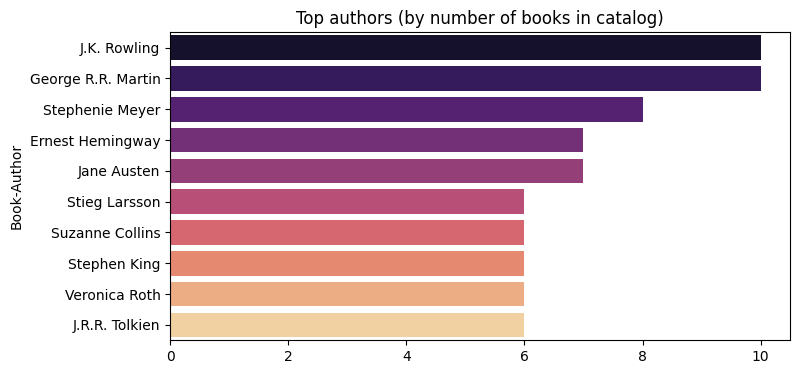

In [5]:
# Find the top 10 authors by the number of books in the catalog
top_authors = books['Book-Author'].value_counts().head(10)

# Plot the top authors
plt.figure(figsize=(8,4))
sns.barplot(x=top_authors.values, y=top_authors.index, palette="magma")
plt.title("Top authors (by number of books in catalog)")
plt.show()

In [6]:
# Print basic statistics about the ratings data
print("Ratings count:", len(ratings))
print("Unique users:", ratings['User-ID'].nunique())
print("Unique books rated:", ratings['ISBN'].nunique())

Ratings count: 1000
Unique users: 1000
Unique books rated: 192


In [7]:
# Create a user-item matrix where rows are users, columns are books, and values are ratings
# Fill any missing values (books not rated by a user) with 0
user_item_matrix = ratings.pivot_table(index='User-ID', columns='ISBN', values='Book-Rating').fillna(0)
print("User-item matrix shape:", user_item_matrix.shape)

User-item matrix shape: (1000, 192)


In [8]:
# Convert the user-item matrix to a sparse matrix format for efficient computation
sparse_matrix = csr_matrix(user_item_matrix.values)

In [9]:
# Initialize and train a K-Nearest Neighbors model for item-based recommendations
# Using 'euclidean' distance and 'brute' algorithm
knn = NearestNeighbors(metric='euclidean', algorithm='brute')
knn.fit(user_item_matrix.T.values) # Train on the transpose of the user-item matrix for item similarity
print("KNN model trained.")

KNN model trained.


In [10]:
# Define a function to recommend books using the trained KNN model
def recommend_books_knn(book_title, n=5):
    # Find the ISBN for the given book title
    isbn_series = books[books['Book-Title'].str.lower() == book_title.lower()]['ISBN']
    if isbn_series.empty:  # Return a message if the book is not found in the dataset
        return f'"{book_title}" not found in dataset.'
    isbn = isbn_series.values[0]
    if isbn not in user_item_matrix.columns:
        # Return a message if the book has not been rated by enough users
        return f'"{book_title}" not popular enough for recommendations.'

    # Get the index of the book in the user-item matrix
    idx = list(user_item_matrix.columns).index(isbn)
    # Extract the row corresponding to the book
    query_vector = user_item_matrix.T.iloc[idx:idx+1].values
    # Find the n nearest neighbors (books) to the query book
    distances, indices = knn.kneighbors(query_vector, n_neighbors=n+1)

    # Print the indices of the recommended books (including the query book itself)
    print(f"Recommendation indices for '{book_title}':", indices.flatten())
    # Get the ISBNs of the recommended books (excluding the query book)
    rec_isbns = [user_item_matrix.columns[i] for i in indices.flatten()[1:]]
    # Get the titles of the recommended books
    rec_books = books[books['ISBN'].isin(rec_isbns)]['Book-Title']
    return rec_books     # Return the recommended book titles

In [11]:
# Recommendation for the below book
recommend_books_knn('A Game of Thrones', n=5)

Recommendation indices for 'A Game of Thrones': [ 26  85  91 174  84  20]


20                                   Pride and Prejudice
85                                          Little Women
86     Don't Sweat the Small Stuff... and It's All Sm...
93                                              Catch-22
176                                   The Scarlet Letter
Name: Book-Title, dtype: object